<a href="https://colab.research.google.com/github/BRomans/IdMind/blob/main/fc_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Load libraries & initialise environment

In [ ]:
from google.colab import drive
import numpy as np
import pandas as pd

# import libraries
from sklearn.preprocessing import MinMaxScaler
from sklearn.externals import joblib
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline

from numpy.random import seed
import tensorflow as tf

from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector, MaxPooling1D
from keras.models import Model
from keras import regularizers

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

In [ ]:
drive.mount("/content/drive")
dirpath = "/content/drive/MyDrive/ml2-eeg-biometrics/train-test-data/" 

In [4]:
# set random seed
seed(10)
tf.compat.v1.set_random_seed(10)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

## Load & Scale Data




In [ ]:
x_train_unscaled = np.load(dirpath + 'x_train.npy')
# y_train = np.load(dirpath + 'y_train.npy')

x_test_unscaled = np.load(dirpath + 'x_test.npy', allow_pickle=True)

print(x_train_unscaled.shape, x_test_unscaled.shape)

In [6]:
cols = ['Statistic','F3', 'F4', 'FC3', 'FC4', 'C3', 'Cz', 'C4', 'CP3', 'CP4']
def data_summary(dataset):
  """ 
  input:
    dataset     the three dimensional input (n_samples, n_timepoints, n_features) 

    Prints histograms for the 9 features individually
  returns: 
    summ_df     pd.DataFrame containing summary statistics for the 9 features.
  """
  data = dataset.reshape((dataset.shape[0] * dataset.shape[1], dataset.shape[2]))
  
  min = data.min(axis=0).reshape(1, data.shape[1])
  max = data.max(axis=0).reshape(1, data.shape[1])
  mean = data.mean(axis=0).reshape(1, data.shape[1])
  var = data.var(axis=0).reshape(1, data.shape[1])
  q01 = np.quantile(data, 0.01, axis=0).reshape(1, data.shape[1])
  q99 = np.quantile(data, 0.99, axis=0).reshape(1, data.shape[1])

  names=np.array([['min','max','mean','var','1st percentile', '99th percentile']]).reshape(6,1)

  summ = np.concatenate((names, np.concatenate((min,max,mean,var,q01,q99),axis=0)), axis=1)
  summ_df = pd.DataFrame(summ, columns=cols)

  # Plot histograms per channel.
  fig, axes = plt.subplots(3,3, figsize = (9,9))
  axes=axes.ravel()
  for i in range(9):
    axes[i].hist(data[:,i], range= (q01[0,i], q99[0,i]),   density=True)
    axes[i].title.set_text(cols[i+1])
  fig.suptitle("Distribution for each channel (between 1st & 99th percentile)", size=16)
  fig.tight_layout(rect=[0, 0.03, 1, 0.95])

  return summ_df

In [ ]:
## Plot distributions of each channel.
data_summary(x_train_unscaled)

#### Smooth out extreme points

In [97]:
# Reshape to 2 dimensional array
x_train = x_train_unscaled.reshape((x_train_unscaled.shape[0]*2500,x_train_unscaled.shape[2]))
x_test = x_test_unscaled.reshape((x_test_unscaled.shape[0]*2500,x_test_unscaled.shape[2]))

# Find the 1st & 99th percentiles for each column of the training data.
q01  = np.quantile(x_train, 0.01, axis=0)
q99  = np.quantile(x_train, 0.99, axis=0)

# Loop through the columns and apply the cutoff
for i in range(x_train.shape[1]):
  x_train[x_train[:,i] < q01[i], i] = q01[i] # If the value is below the 1st percentile, replace with the 1st percentile.
  x_train[x_train[:,i] > q99[i], i] = q99[i] # If the value is above the 99th percentile, replace with the 99th percentile.
  # Do the same with the test data, using the cutoffs calculated from the training data.
  x_test[x_test[:,i] < q01[i], i] = q01[i] 
  x_test[x_test[:,i] > q99[i], i] = q99[i] 

In [98]:
# normalize the data
scaler = MinMaxScaler()

x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
scaler_filename = "/content/drive/MyDrive/ml2-eeg-biometrics/scaler_data"
joblib.dump(scaler, scaler_filename)

['/content/drive/MyDrive/ml2-eeg-biometrics/scaler_data']

In [99]:
# Take a subset of the data - only one feature, every 5 timepoints, to test different AE configurations.
x_train_1f = x_train[::5,0]
x_train_1f = x_train_1f.reshape((int(len(x_train_1f)/500), 500)) # Reshape so that the timepoints represent columns.

# reshape inputs for plain autoencoder, i.e. flatten the 2,500x9 values as the columns.
x_train = x_train.reshape((int(x_train.shape[0]/2500), 2500 * x_train.shape[1]))
x_test = x_test.reshape((int(x_test.shape[0]/2500), 2500 * x_test.shape[1]))
print("Shapes: ", x_train.shape, x_test.shape)

Shapes:  (6665, 22500) (419, 22500)


In [ ]:
data_summary(x_train)

## Visualise the Raw & Scaled Signals

In [ ]:
labels=[(('F3',0), ('F4',1)), (('FC3',2), ('FC4',3)), (('C3',4), ('Cz',5), ('C4',6)), (('CP3',7), ('CP4',8))]
colours= ['darkslateblue', 'orange','lightskyblue','brown','darkgreen','darkgrey','bisque','violet','palegreen']

def plot_signals(sample, title=None):
  fig, axes = plt.subplots(2,2, figsize = (6,6))
  axes=axes.ravel()
  plt.suptitle("Signals" if title is None else title, size=16)
  count=0
  for label_group in labels:
    for label, ind in label_group:
      axes[count].plot(sample[:,ind], label=label,color=colours[ind], alpha=0.8)
      axes[count].legend()
    count+=1

plot_signals(x_train[101], title="Scaled Signals - x_train[0]")
plot_signals(x_train_unscaled[101], title="Unscaled Signals - x_train[0]")

## LSTM Autoencoder

In [102]:
# define the autoencoder network model (Keras)
def autoencoder_model(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = LSTM(18, activation='tanh', return_sequences=True, 
              kernel_regularizer=regularizers.l2(0.00))(inputs)
    L2 = LSTM(450, activation='tanh', return_sequences=False)(L1)
    L3 = RepeatVector(X.shape[1])(L2)
    L4 = LSTM(450, activation='tanh', return_sequences=True)(L3)
    L5 = LSTM(18, activation='tanh', return_sequences=True)(L4)
    output = TimeDistributed(Dense(X.shape[2]))(L5)    
    model = Model(inputs=inputs, outputs=output)
    return model

In [125]:
# define the autoencoder network model (Keras)
def fc_autoencoder_model(X):
    inputs = Input(shape=(500,))
    e1 = Dense(225, activation='relu')(inputs)
    e2 = Dense(150, activation='relu')(e1)
    e3 = Dense(70, activation='relu')(e2)  
    encoded = Dense(70, activation='relu')(e3)
    d1 = Dense(70, activation='relu')(encoded)  
    d2 = Dense(150, activation='relu')(d1)
    d3 = Dense(225, activation='relu')(d2)
    decoded = Dense(X.shape[1], activation='sigmoid')(d3)

    model = Model(inputs=inputs, outputs=decoded)
    return model

In [126]:
# create the autoencoder model
# x_subs = x_train[:,::100]

model = fc_autoencoder_model(x_train_1f)
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "model_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        [(None, 500)]             0         
_________________________________________________________________
dense_94 (Dense)             (None, 225)               112725    
_________________________________________________________________
dense_95 (Dense)             (None, 150)               33900     
_________________________________________________________________
dense_96 (Dense)             (None, 70)                10570     
_________________________________________________________________
dense_97 (Dense)             (None, 70)                4970      
_________________________________________________________________
dense_98 (Dense)             (None, 70)                4970      
_________________________________________________________________
dense_99 (Dense)             (None, 150)               106

In [121]:
# fit the model to the data
nb_epochs = 1000
batch_size = 100
history = model.fit(x_train_1f, x_train_1f, epochs=nb_epochs,
                    batch_size=batch_size,
                    # validation_split=0.05
                    ).history

Epoch 1/1000
67/67 [==============================] - 1s 3ms/step - loss: 0.0883
Epoch 2/1000
67/67 [==============================] - 0s 3ms/step - loss: 0.0716
Epoch 3/1000
67/67 [==============================] - 0s 3ms/step - loss: 0.0688
Epoch 4/1000
67/67 [==============================] - 0s 3ms/step - loss: 0.0677
Epoch 5/1000
67/67 [==============================] - 0s 2ms/step - loss: 0.0634
Epoch 6/1000
67/67 [==============================] - 0s 2ms/step - loss: 0.0594
Epoch 7/1000
67/67 [==============================] - 0s 2ms/step - loss: 0.0555
Epoch 8/1000
67/67 [==============================] - 0s 2ms/step - loss: 0.0546
Epoch 9/1000
67/67 [==============================] - 0s 2ms/step - loss: 0.0533
Epoch 10/1000
67/67 [==============================] - 0s 2ms/step - loss: 0.0529
Epoch 11/1000
67/67 [==============================] - 0s 2ms/step - loss: 0.0525
Epoch 12/1000
67/67 [==============================] - 0s 2ms/step - loss: 0.0521
Epoch 13/1000
67/67 [====

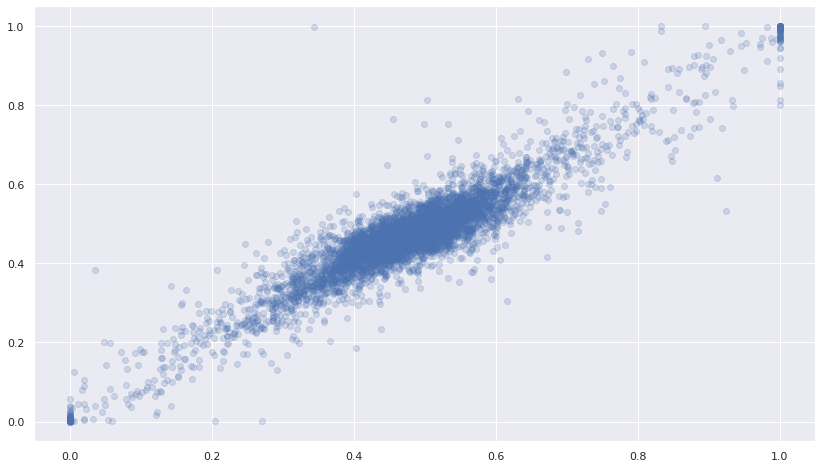

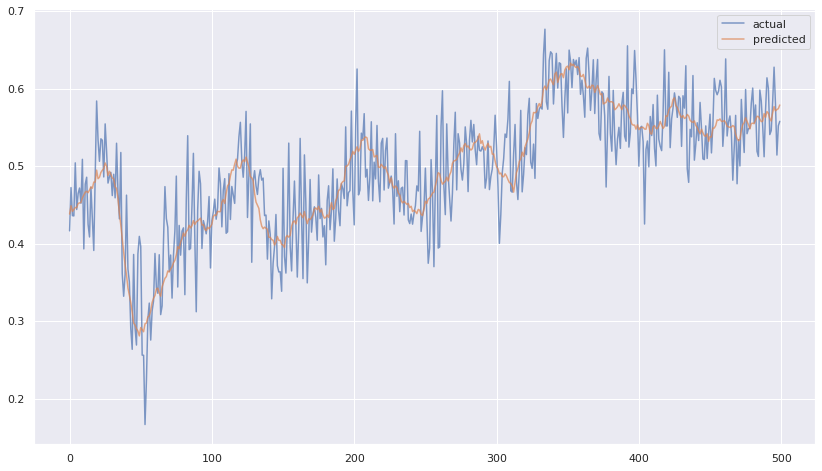

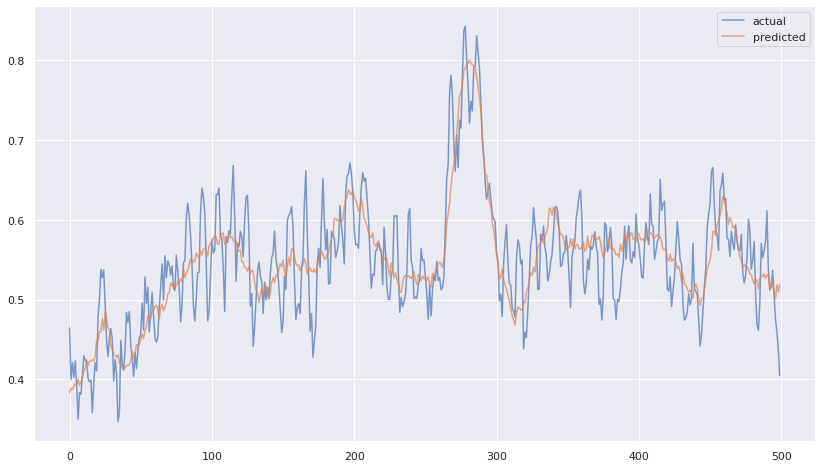

In [123]:
# Plot samples.
x_pred = model.predict(x_train_1f)

# Plot actuals vs. prediction for one column across all rows
plt.figure(figsize=(14,8))
plt.scatter(x_train_1f[:,0], x_pred[:,0],alpha=0.2)
plt.show()

# Plot actuals vs. predictions for one row across all columns
plt.figure(figsize=(14,8))
plt.plot(x_train_1f[0,:], label='actual', alpha=0.7)
plt.plot(x_pred[0,:], label= 'predicted',alpha=0.7)
plt.legend()

# Plot same as above for a different row
plt.figure(figsize=(14,8))
plt.plot(x_train_1f[1039,:], label='actual', alpha=0.7)
plt.plot(x_pred[1039,:], label= 'predicted',alpha=0.7)
plt.legend()

In [ ]:
# plot the training losses
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()


## Evaluate Results

In [ ]:
# Get the predicted values for the training set.
X_pred_3D = model.predict(x_train)
X_pred = X_pred_3D.reshape(X_pred_3D.shape[0]*X_pred_3D.shape[1], X_pred_3D.shape[2])
# X_pred = pd.DataFrame(X_pred, columns=train.columns)

In [ ]:
# Plot the distribution of the loss
x_train_reshaped = x_train.reshape(x_train.shape[0]*x_train.shape[1], x_train.shape[2])
loss_mae = np.mean(np.abs(X_pred-x_train_reshaped), axis = 1)
plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution', fontsize=16)
sns.distplot(loss_mae, bins = 20, kde= True, color = 'blue');
plt.xlim([0.0,.5])

In [ ]:
cols = ['F3', 'F4', 'FC3', 'FC4', 'C3', 'Cz', 'C4', 'CP3', 'CP4']

def evaluate_prediction(actuals, pred, ind, rescale=False):
  """ Function to plot predictions vs. the actuals for one sample.
  input:
    actuals   3D array (n_samplesx2500x9) - Original scaled signals.
    pred      the predicted values corresponding to the actuals.
    ind     The row number of the sample (2500x9) that you want to compare.
    rescale   If set to true then the data is first converted back to the original scale for comparison.
  
  returns:
    nothing

  prints plots.
  """
  if rescale:
    sample_actual = scaler.inverse_transform(actuals[ind]) # Rescale to the original scale.
    sample_pred = scaler.inverse_transform(pred[ind]) 
  else:
    sample_actual = actuals[ind]    # Get the relevant sample.
    sample_pred = pred[ind]

  mae_by_channel = np.mean(np.abs(sample_pred - sample_actual), axis=0) # Get the Mean Absolute Error for each channel for this sample
  sample_mae = np.mean(mae_by_channel) # Get the total MAE for the sample by taking the average across the 9 channels
  print("Sample", ind, "\n   Total Mean Absolute Error:", round(sample_mae, 8))
  print("Mean Absolute Error by Channel:")
  for col, error in zip(cols, mae_by_channel):
    print(col, ": ", round(error,8)) 

  fig, axes = plt.subplots(3,3, figsize=(9,9))
  axes=axes.ravel()

  for i in range(9):
    axes[i].plot(sample_actual[:,i], label= "Actual")
    axes[i].plot(sample_pred[:,i], label="Predicted")
    axes[i].title.set_text(cols[i] + str(round(mae_by_channel[i], 3)))
  
  plt.legend()
  fig.suptitle("Predictions vs. Actuals - Sample " + str(ind),size=16)
  fig.tight_layout(rect=[0, 0.03, 1, 0.95])

evaluate_prediction(x_train, X_pred_3D, ind=1, rescale=False)

In [ ]:
X_pred_3D[3000][1000:1100, 1]

In [ ]:
np.mean(np.abs(X_pred_3D[0] - x_train[0]), axis=1)[0:20]

In [ ]:
# plot the loss distribution of the test set
X_pred = model.predict(x_test)
X_pred = X_pred.reshape(X_pred.shape[0]*X_pred.shape[1], X_pred.shape[2])

x_test_reshaped = x_test.reshape(x_test.shape[0]*x_test.shape[1], x_test.shape[2])
fig, axes = plt.subplots(9,1, figsize=(18,9))
# Plot the loss distribution for each channel individually
for i in range(x_test_reshaped.shape[1]):
  loss_mae = np.abs(X_pred[:,i]-x_test_reshaped[:,i])
  sns.distplot(loss_mae, bins = 100, kde= True, color = 'blue', ax=axes[i]);
  axes[i].axis(xmin=0.0,xmax=0.2)

In [ ]:
# save all model information, including weights, in h5 format
model.save("/content/drive/MyDrive/ml2-eeg-biometrics/model1_rw.h5")
print("Model saved")

# Convolutional Autoencoder

In [ ]:
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.utils import to_categorical

In [ ]:
# cnn model

# fit and evaluate a model
def evaluate_model(trainX, trainy, testX, testy, n_filters):
  verbose, epochs, batch_size = 0, 10, 32
  n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
  model = Sequential()
  model.add(Conv1D(filters=n_filters, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
  model.add(Conv1D(filters=n_filters, kernel_size=3, activation='relu'))
  model.add(Dropout(0.5))
  model.add(MaxPooling1D(pool_size=2))
  model.add(Flatten())
  model.add(Dense(100, activation='relu'))
  model.add(Dense(n_outputs, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  # fit network
  model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
  # evaluate model
  _, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
  return accuracy

In [ ]:
# summarize scores
def summarize_results(scores, params):
  print(scores, params)
  # summarize mean and standard deviation
  for i in range(len(scores)):
    m, s = mean(scores[i]), std(scores[i])
    print('Param=%d: %.3f%% (+/-%.3f)' % (params[i], m, s))
  # boxplot of scores
  pyplot.boxplot(scores, labels=params)
  pyplot.savefig('exp_cnn_filters.png')

In [ ]:
# run an experiment
def run_experiment(params, repeats=10):
  # test each parameter
  all_scores = list()
  for p in params:
    # repeat experiment
    scores = list()
    for r in range(repeats):
      score = evaluate_model(x_train, y_train, x_test, y_test, p)
      score = score * 100.0
      print('>p=%d #%d: %.3f' % (p, r+1, score))
      scores.append(score)
    all_scores.append(scores)
  # summarize results
  summarize_results(all_scores, params)

In [ ]:
# run the experiment
n_params = [8, 16, 32, 64, 128, 256]
run_experiment(n_params)